# Part 1: Create database set
By inputting a target gene, a nested dictionary will be created, with each key being the name of a cancer and each value being a dictionary containing the genomic, proteomic, transcriptomic, and phosphoproteomic data. In other words, the dictionary will be:

{
    cancer : {   
    
            "gen" : <cancer's genomic data>,
            "prot" : <cancer's proteomic data>,
            "trans": <cancer's transcriptomic data>,
            "phos": <cancer's phosphoproteomic data>
        }
    ... for each cancer
}

In [85]:
import cptac
import cptac.pancan as pc
import numpy as np
import cptac.utils as ut
# from cptac.utils import plot_utils as plt_ut
from cptac.exceptions import InvalidParameterError
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import cProfile

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset_names = ['Brca', 'Ccrcc', 'Coad', 'Gbm', 'Hnscc', 'Lscc', 'Luad', 'Ov', 'Ucec', 'Pdac']
dataset_names

['Brca', 'Ccrcc', 'Coad', 'Gbm', 'Hnscc', 'Lscc', 'Luad', 'Ov', 'Ucec', 'Pdac']

In [4]:
target_gene = "TP53"

In [5]:
# Indicate the NUMERICAL INDICES of the pathways of interest
path_indices=[0, 1, 2, 10, 18]

In [128]:
paths

,id,pathway
0,TP53,MAPK Signaling Pathway
1,TP53,DNA Damage Response
2,TP53,Wnt Signaling Pathway and Pluripotency
3,TP53,Pathways Affected in Adenoid Cystic Carcinoma
4,TP53,Retinoblastoma Gene in Cancer
5,TP53,Mammary gland development pathway - Involution...
6,TP53,miRNA regulation of p53 pathway in prostate ca...
7,TP53,miRNA Regulation of DNA Damage Response
8,TP53,Ultraconserved region 339 modulation of tumor ...
9,TP53,Gastric Cancer Network 2


In [6]:
# List of pathways to select for the trans analysis
paths = ut.get_pathways_with_proteins(proteins = target_gene, database = 'wikipathways')
if path_indices==[]:
    paths
else:
    print(f"Indices [{', '.join([str(i) for i in path_indices])}] selected!")

Indices [0, 1, 2, 10, 18] selected!


In [7]:
datasets = {}
for name in dataset_names:
    print(f"Loading {name}...")
    exec(f"cancer = cptac.{name}()")
    genotype_data = cancer.get_genotype_all_vars(mutations_gene=target_gene, omics_source = "washu", mutations_source="washu")
    genotype_data.astype({'Mutation':'category', 'Mutation_Status':'category'})
    
    proteomic_data = cancer.get_proteomics(source = 'umich')
    proteomic_data = proteomic_data.droplevel("Database_ID", axis = 1)
    proteomic_data = proteomic_data.astype({col: 'float32' for col in proteomic_data.columns})
    
    phospho_data = cancer.get_phosphoproteomics(source = 'umich')
    phospho_data = phospho_data.droplevel("Database_ID", axis = 1).droplevel("Peptide", axis = 1)
    phospho_data = phospho_data.astype({col: 'float32' for col in phospho_data.columns})
          
    
    transcript_data = cancer.get_transcriptomics(source = "washu")
    transcript_data = transcript_data.droplevel("Database_ID", axis = 1)
    transcript_data = transcript_data.astype({col: 'float32' for col in transcript_data.columns})
paths = ut.get_pathways_with_proteins(proteins = target_gene, database = 'wikipathways')

    
    datasets[name] = {
                        "gen" : genotype_data,
                        "prot": proteomic_data,
                        "trans": transcript_data,
                        "phos" : phospho_data
                     }    
    


Loading Brca...
Loading Ccrcc...                                         
Loading Coad...                                           
Loading Gbm...                                           
Loading Hnscc...                                        
Loading Lscc...                                           
Loading Luad...                                          
Loading Ov...                                            
Loading Ucec...                                        
Loading Pdac...                                          


# Part 2: Select mutations
Determine which cancers have mutation types with rates above 20%.

To facilitate that, the mutation types from the get_genotype_all_vars must be grouped into functional types.


In [8]:
mutation_types = ["Deletion", "Amplification", "Truncation", "Indel", "Missense"]

omics_key = {"prot":"proteomics", "trans":"transcriptomics","phos":"phosphoproteomics"}

In [9]:
# Grouping the mutation types for each cancer
for name, dataset in datasets.items():
    genotypes = dataset["gen"]
    print(genotypes)
    genotypes.replace(["Nonsense_Mutation", "Frame_Shift_Ins", "Frame_Shift_Del"], "Truncation", inplace = True)
    genotypes.replace(["In_Frame_Del", "In_Frame_Ins"], "Indel", inplace = True)
    genotypes.replace(["Missense_Mutation", "Wildtype_Tumor"], ["Missense", "Wildtype"], inplace = True)
    genotypes = genotypes.loc[~genotypes["Mutation"].isin(["Intron","Silent"])]
    datasets[name]["gen"] = genotypes

Name                 Mutation       Location    Mutation_Status
Patient_ID                                                     
01BR001     Missense_Mutation        p.R249N  Multiple_mutation
01BR008     Missense_Mutation        p.Y220C    Single_mutation
01BR009         Amplification  Amplification    Single_mutation
01BR010        Wildtype_Tumor    No_mutation     Wildtype_Tumor
01BR015     Missense_Mutation        p.P278T    Single_mutation
...                       ...            ...                ...
21BR010              Deletion       Deletion    Single_mutation
22BR005     Nonsense_Mutation         p.W91*    Single_mutation
22BR006        Wildtype_Tumor    No_mutation     Wildtype_Tumor
CPT000814     Frame_Shift_Del   p.E204Sfs*43    Single_mutation
CPT001846   Missense_Mutation        p.C176Y    Single_mutation

[122 rows x 3 columns]
Name              Mutation     Location    Mutation_Status
Patient_ID                                                
C3L-00004   Wildtype_Tumor

Mutation,Amplification,Deletion,Missense,Splice_Site,Truncation,Wildtype
Brca,5.0,32.0,21.0,3.0,16.0,45.0
Ccrcc,1.0,5.0,3.0,0.0,0.0,101.0
Coad,0.0,57.0,10.0,0.0,10.0,28.0
Gbm,2.0,14.0,18.0,0.0,3.0,60.0
Hnscc,1.0,14.0,48.0,5.0,30.0,11.0
Lscc,1.0,42.0,39.0,3.0,20.0,4.0
Luad,1.0,39.0,27.0,1.0,9.0,33.0
Ov,1.0,40.0,24.0,2.0,10.0,4.0
Ucec,0.0,9.0,8.0,0.0,5.0,71.0
Pdac,0.0,31.0,50.0,7.0,18.0,32.0


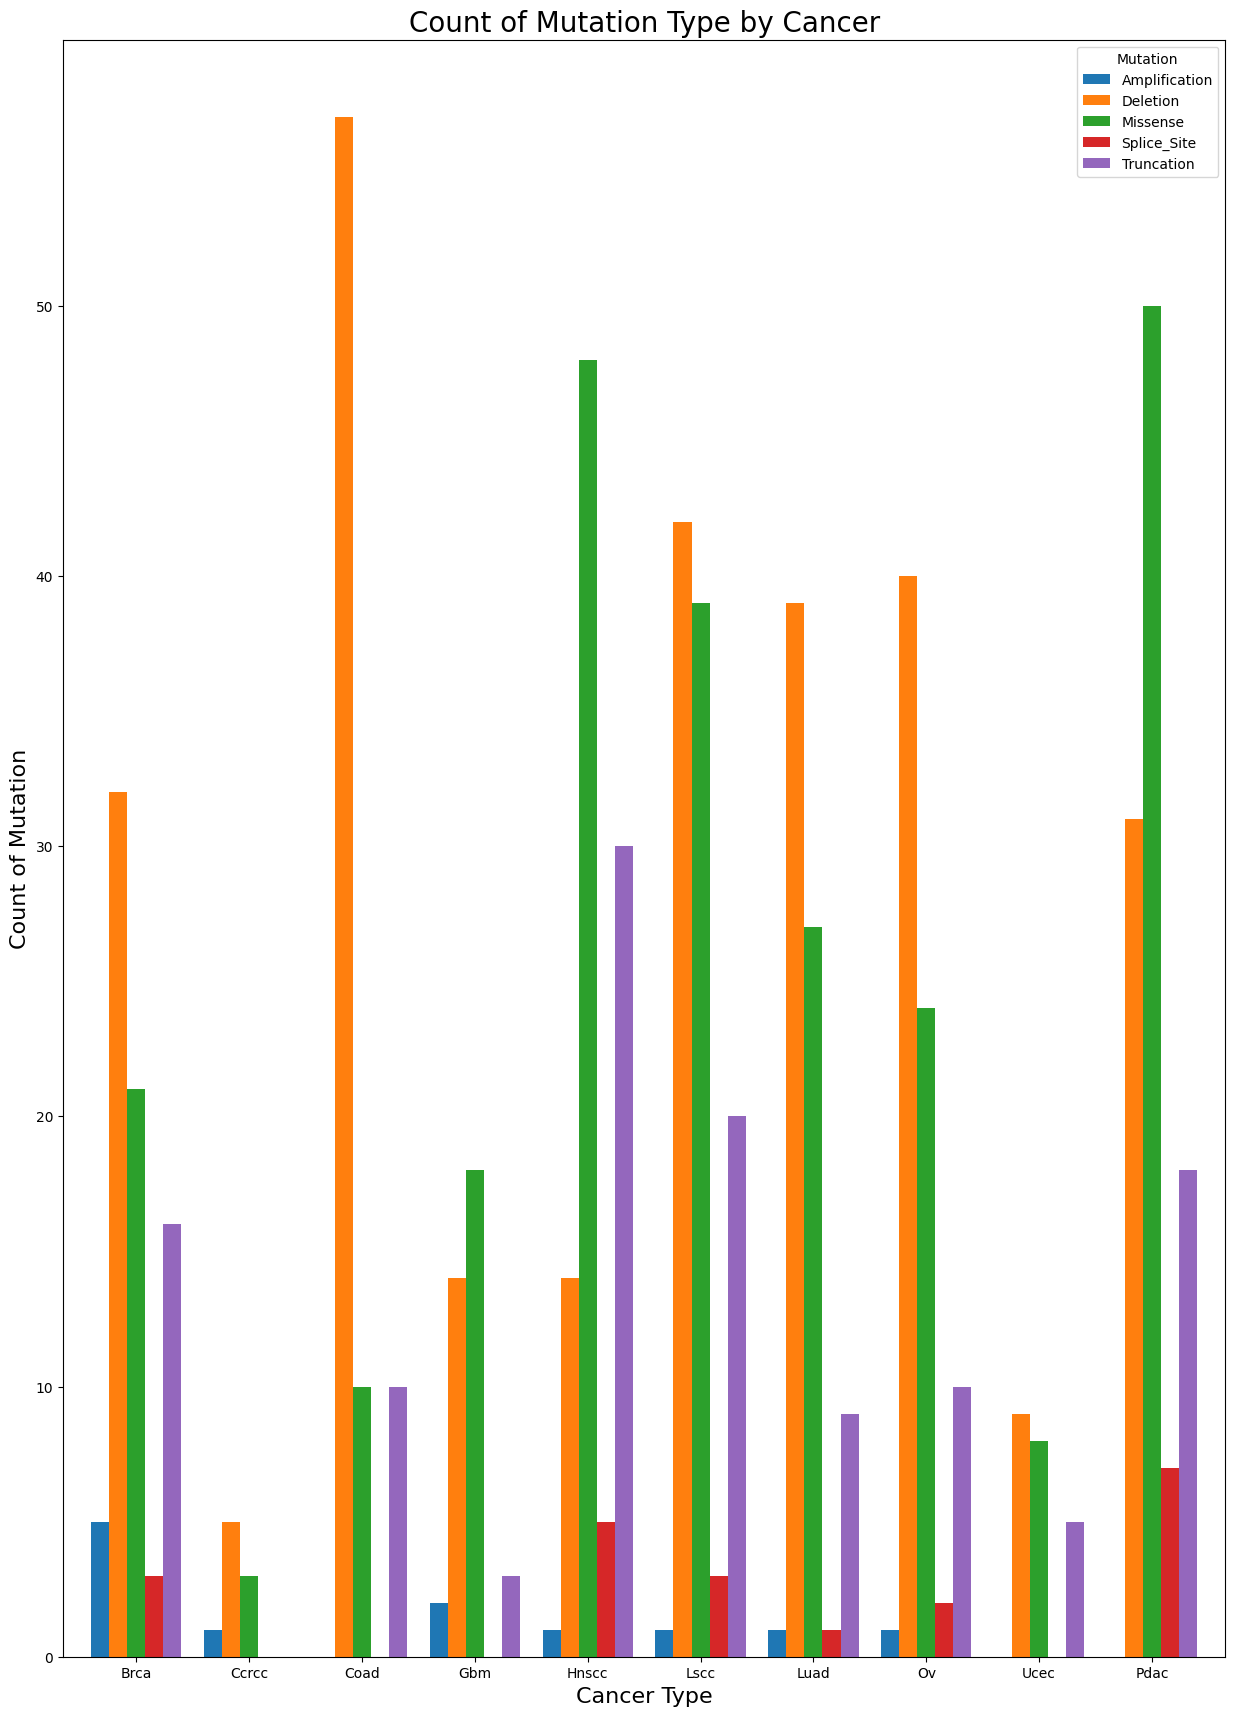

In [10]:
# Create a bargraph displaying the mutation types
plt.rcParams["figure.figsize"] = [15,21]
mutation_data = pd.DataFrame()
for cancer, dataset in datasets.items():
    mutation_data[cancer]= datasets[cancer]["gen"].groupby("Mutation").count()["Location"]
mutation_data = mutation_data.fillna(0)
mutation_data = mutation_data.transpose()#.drop(columns="Wildtype")
mutation_data.drop(columns="Wildtype").plot.bar(rot=0, width=0.8)

plt.xlabel("Cancer Type", fontsize=16)
plt.ylabel("Count of Mutation", fontsize=16)
plt.title("Count of Mutation Type by Cancer"paths = ut.get_pathways_with_proteins(proteins = target_gene, database = 'wikipathways')
, fontsize=20)
plt.savefig('Cis_Effect_output/Mutation_Count.png')
mutation_data


In [11]:
# Determine which cancers have mutation rates over 20%
variants_to_analyze = {}
for name, dataset in datasets.items():
    mut_type_freq = dataset["gen"]["Mutation"].value_counts() / len(dataset["gen"])
    
    mut_type_freq = mut_type_freq.loc[mut_type_freq >= 0.2]
    variants_to_analyze[name] = set(mut_type_freq.index.tolist())
    variants_to_analyze[name].discard("Wildtype")
print(str(variants_to_analyze))

{'Brca': {'Deletion'}, 'Ccrcc': set(), 'Coad': {'Deletion'}, 'Gbm': set(), 'Hnscc': {'Truncation', 'Missense'}, 'Lscc': {'Missense', 'Deletion'}, 'Luad': {'Missense', 'Deletion'}, 'Ov': {'Missense', 'Deletion'}, 'Ucec': set(), 'Pdac': {'Deletion', 'Missense'}}


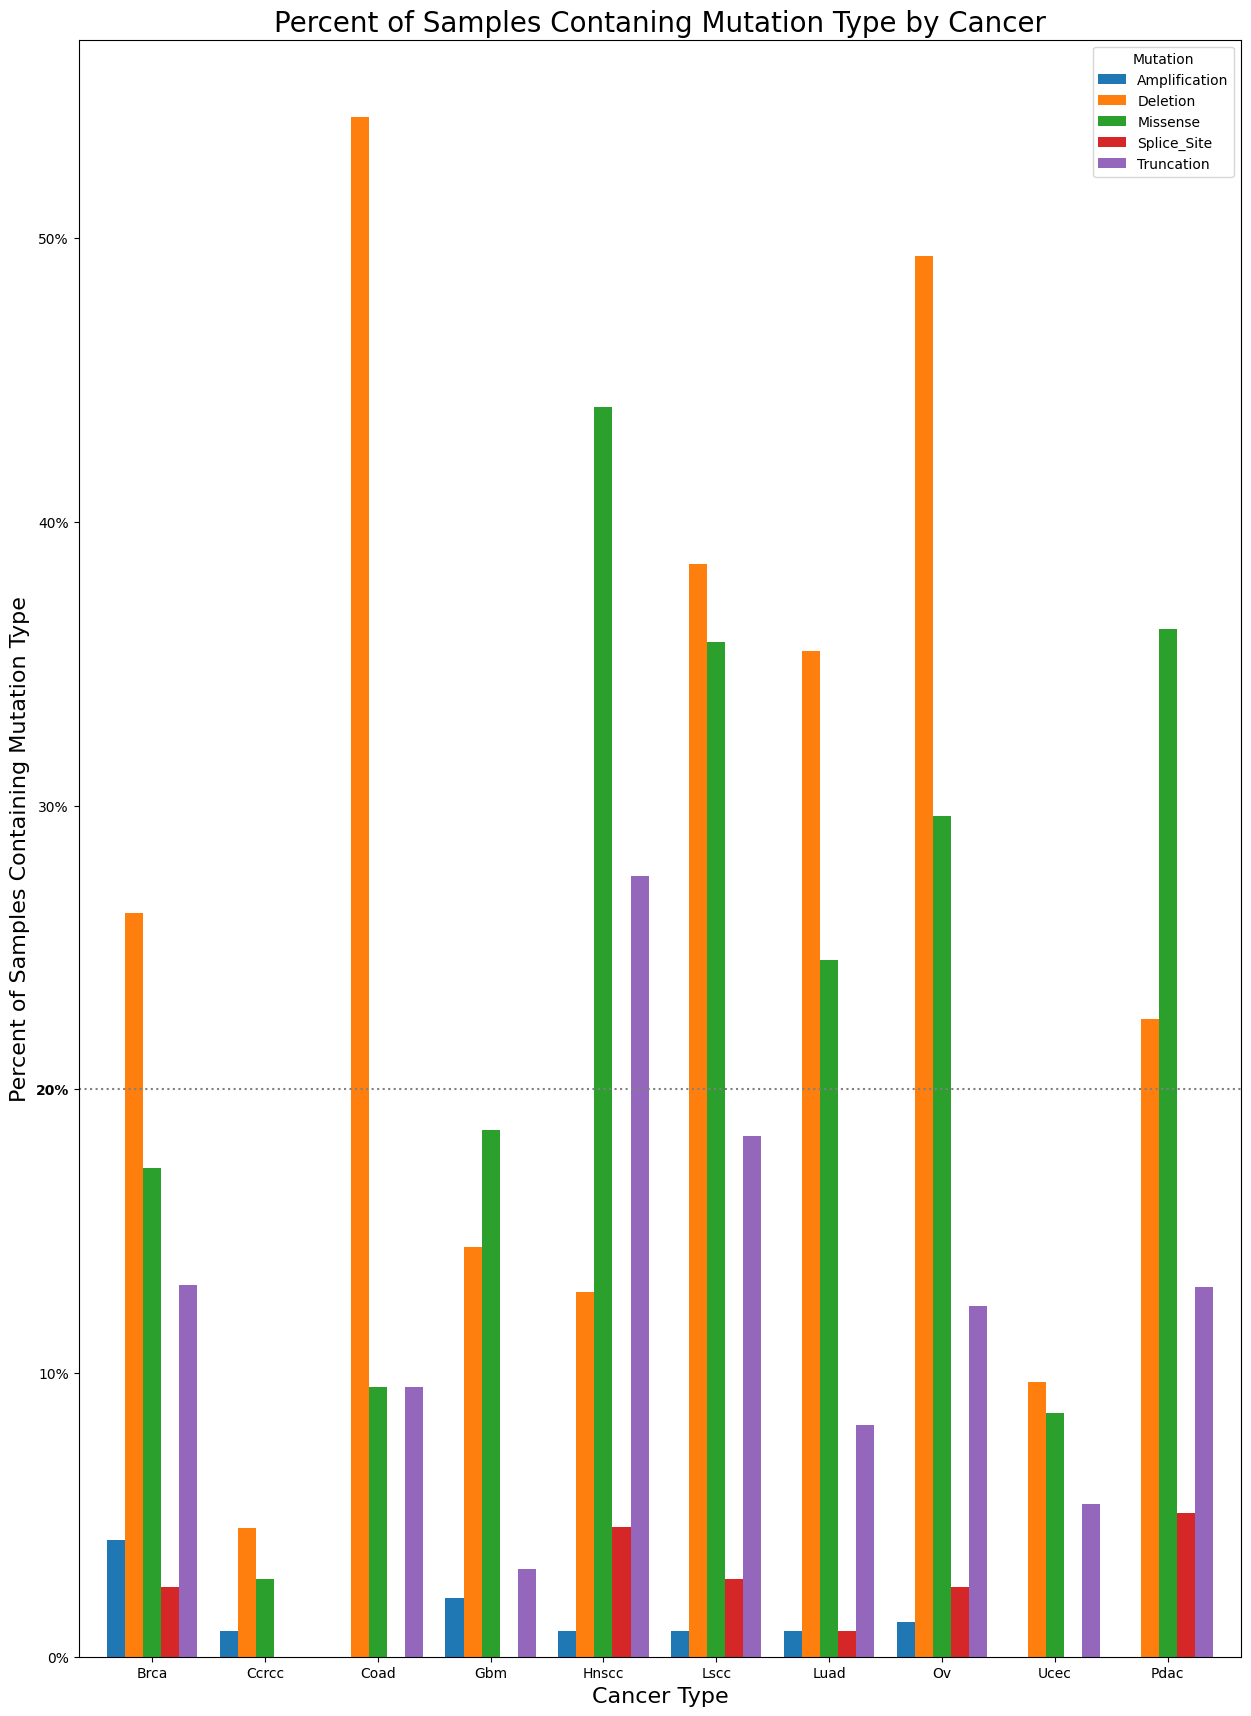

In [13]:
mutation_data = mutation_data.apply(lambda row: row / row.sum(), axis=1)
ax = mutation_data.drop(columns="Wildtype").plot.bar(rot=0, width=0.8)
plt.axhline(y=0.2, xmin=0, xmax=1, linestyle="dotted", color="grey")

plt.xlabel("Cancer Type", fontsize=16)
plt.ylabel("Percent of Samples Containing Mutation Type", fontsize=16)
plt.title("Percent of Samples Contaning Mutation Type by Cancer", fontsize=20)
ax.set_yticklabels(["{:,.0%}".format(val) for val in ax.get_yticks()])
ax.get_yticklabels()[2].set_weight("bold")
plt.savefig('Cis_Effect_output/Mutation_Proportions.png')
plt.show()

In [14]:
# plt.figure1_plot_mutations(datasets.values(), list(datasets.keys()), save_to_path = "Test_Figure.png")

# Part 3: Cis effects
Determines which genes that, given a mutation, will change the expression in their own proteomics, transcriptomics, or phosphoproteomics.This analysis is repeated for every cancer, and every mutation type.

Writes out a file containing the infomation for each mutation and cancer, and creates boxplot summarizing the data

In [29]:
'''
Parameters
pval_symbol: String. The symbol associated with the significance of the pvalue (NS, *, **, or ***)
x1, x2: Float. x coordinates for the start and end of the annotation line.
line_start: Float. y coordinate for the horizontal line (Default = .05).
line_height: Float. The height of the vertical lines at the start and end of the horizontal line (Default = .05).

Returns a formated annotation line showing the significance symbol of each pvalue.
'''
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

In [107]:
def generate_cis_plot(boxplot_data, omics_type, pval_df):
    plt.rcParams['figure.figsize'] = (15,10) # size of plot
#     if len(gene_list) > 15:
#         plt.rcParams['figure.figsize']=(20,10)
    sns.set(font_scale = 1.2, style = "white")

    for site in boxplot_data["Site"].unique():
        mutations = sorted(boxplot_data["Mutation"].unique(), reverse = True)
        boxplot = sns.boxplot(x = "cancer_type", y = "P_Value", hue = "Mutation", showfliers = False, 
                              data = boxplot_data[boxplot_data["Site"] == site], hue_order = mutations)
        boxplot = sns.stripplot(x = "cancer_type", y = "P_Value", hue = "Mutation", jitter = True, hue_order = mutations,
                               color = ".3", dodge = True, data = boxplot_data[boxplot_data["Site"] == site])
#         gene_site = site if site == target_gene else target_gene+'.'+site
        gene_site = site
        boxplot.set(xlabel = "", ylabel = f"{gene_site}_{omics_key[omics_type]}")
        boxplot.set(title = f"Pancan Analysis of {gene_site} {omics_key[omics_type].capitalize()} Mutations")
#         if len(gene_list) > 15:
#             boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=50)
        
        num = len(boxplot_data["Mutation"].unique())
        handles, labels = boxplot.get_legend_handles_labels()
        legend = plt.legend(handles[0:num], labels[0:num], loc = "lower right")
        
        ## CREATE PVAL ANNOTATIONS
        symbols = {}
        start = -0.3
        cancer_list = boxplot.get_xticklabels() # get a list of cancer types actually plotted 
        first_mutation = mutations[1]
        bottom,top = plt.ylim()
        annot_size = top + 0.5
        annot_scale = (top - bottom) * 0.05 # sets annotation height between mutations based on y-axis scale
        for cancer in cancer_list:
            cancer = cancer.get_text()
            mutation_list = sorted(boxplot_data.loc[boxplot_data["cancer_type"] == cancer]["Mutation"].unique().tolist(),
                                   reverse = True)
            mutation_list.remove("Wildtype")
            offset = 0.4
            annot_offset = annot_scale
            for mutation in mutation_list:
                pval = pval_df.loc[(pval_df["Cancer"] == cancer)&(pval_df["Mutation"] == mutation)&
                                   (pval_df["Site"] == site)]['P_Value']
                if pval.tolist():
                    pval = pval.tolist()[0]
                    if pval  <= 0.001:
                         symbols[cancer] = '***'
                    elif pval  <= 0.01:
                        symbols[cancer] = '**'  
                    elif pval <= 0.05:
                        symbols[cancer] = '*'
                    else:
                        symbols[cancer] = 'ns'
                    if mutation == first_mutation:
                        format_pval_annotation(symbols[cancer], start, start + 0.2, annot_size)
                    else:
                        format_pval_annotation(symbols[cancer], start, start + offset, annot_size + annot_offset)
                        offset += 0.2
                        annot_offset += annot_scale
            start += 1
        plot_name = omics_type.title()
        if site != target_gene:
            plot_name += '_' + site
        plt.savefig(f"Cis_Effect_output/{plot_name}_Mutations.png")
        plt.show()
        plt.clf()
        plt.close()
            
#         fig = boxplot.get_figure()
#         fig.savefig(f"Cis_Effect_output/Test_{gene_site}_{omics_key[omics_type]}.png")
#         fig.clf()

In [126]:
def analyze_cis_mutation(omics_type, genes_to_analyze = [target_gene], write_out = True, file_name = None, output_boxplot = True, write_insignificant=False):
    """Analyzes the cis effects for a given mutation type across all cancers.
    
    Parameters:
    omics_type (str): The omics to analyze. Possible values are in list ["prot", "trans", "phos"]
    genes_to_analyze (list): A list of strings representing genes to analyze. For cis effects, this is always [target_gene]
    write_out (bool, default=True): Whether to write out the data to a separate file.
    output_boxplot (bool, default=True): Outputs the data as a boxplot given by the generate_cis_plot function
    write_insignificant (bool, default=True): Returns data only when the p-value <= 0.05. If write_out, it only writes out the data under that condition.
    
    Returns a dataframe containing output of scipy.ttest_ind() between "Wildtype" and mutation_type tumors.
    """
    if write_out:# Sets file name and clears target files
        if file_name is None:
            effect_type = "Cis" if genes_to_analyze == [target_gene] else "Trans"
            file_name = f"{effect_type}_Effect_output/{omics_key[omics_type].capitalize()}_Analysis.txt" 
            if '/' in file_name:
                directory = file_name[:file_name.rfind('/')]
                if not os.path.exists(directory):
                    os.makedirs(directory)
        with open(file_name, 'w') as out_file: pass
                
           
    result = pd.DataFrame()
    for cancer_type, dataset in datasets.items():
        ## PREPARE DATA ##
        genotype_and_omic = dataset[omics_type].copy()
        if isinstance(genotype_and_omicpaths = ut.get_pathways_with_proteins(proteins = target_gene, database = 'wikipathways')
.columns, pd.MultiIndex):
            genotype_and_omic.columns = ['_'.join(col) for col in genotype_and_omic.columns.values]
        if genes_to_analyze is not None:
            genotype_and_omic = genotype_and_omic.filter(regex='(' + '|'.join(genes_to_analyze) + ')(_.*)?$', axis=1)
        else:
            genotype_and_omic.drop(target_gene, axis = 1, inplace=True)
        genotype_and_omic["Mutation"] = dataset["gen"]["Mutation"].copy()
        genotype_and_omic = genotype_and_omic.loc[:,~genotype_and_omic.columns.duplicated()]
#         genotype_and_omic = genotype_and_omic.dropna()
        
        for mutation_type in mutation_types:
            if mutation_type not in variants_to_analyze[cancer_type]: 
                continue
                    
            print(f"   {cancer_type} {mutation_type}s") #debug temp
            target_mut_data = genotype_and_omic.loc[genotype_and_omic["Mutation"].isin(["Wildtype", mutation_type])]
            ## ANALYZE P-VALUES ##
            # DIFF b/w trans effects: loops through each column to avoid correction
            for site in target_mut_data.drop("Mutation", axis=1).columns:
                test_data = target_mut_data[[site, 'Mutation']].dropna()
                try:
                    mutation_analysis = ut.wrap_ttest(test_data, label_column="Mutation",
                                    correction_method = "fdr_bh", return_all=True)
                except (InvalidParameterError, ValueError) as e:
                    print(f"    Not enough values for {site}")
                    continue
                mutation_analysis.rename({'Comparison':'Site'}, axis = 1, inplace = True)
                mutation_analysis['Cancer'], mutation_analysis['Mutation'] = cancer_type, mutation_type
            
                result = pd.concat([result, mutation_analysis])

            #END DIFF
            
                ## GATHER DATA FOR BOXPLOT ##
                if output_boxplot:
                    new_data = test_data[(genotype_and_omic["Mutation"] == mutation_type)|
                                                (genotype_and_omic["Mutation"] == "Wildtype")]
                    new_data["Site"], new_data["cancer_type"] = site, cancer_type
                    new_data.rename({site:"P_Value"}, axis=1, inplace=True)
                    try:
                        boxplot_data = pd.concat([boxplot_data, new_data], axis=0)
                    except NameError:
                        boxplot_data = new_data
                        
    result.drop_duplicates(inplace=True)

            ## WRITE OUT RESULT ##
    if write_out:
        with open(file_name, 'a') as out_file:
            output = result.copy()
            if not write_insignificant:
                output = output.loc[output['P_Value'] <= 0.05]
            
            print(result)
            for cancer, mutation in output[["Cancer", "Mutation"]].value_counts().index:
                mut_data = output.loc[(output["Cancer"] == cancer)&(output["Mutation"] == mutation)]
                out_file.write(f"{cancer.upper()} {mutation.upper()}: ")
                out_file.write(f"{len(mupaths = ut.get_pathways_with_proteins(proteins = target_gene, database = 'wikipathways')
t_data.loc[mut_data['P_Value'] <= 0.05])} significant entries\n")
                for row in mut_data.iterrows():
                    data = row[1]
                    out_file.write(f"   {data['Site']}:".ljust(15) + f"{data['P_Value']}\n")
                out_file.write('\n')

    ## CREATE BOXPLOT ##
    if output_boxplot:
        print(boxplot_data[boxplot_data['P_Value'].isna()]['cancer_type'].value_counts())
        generate_cis_plot(boxplot_data, omics_type, result) 

    result.reset_index(drop=True, inplace=True)
    result["Omics"] = omics_type
    return result

   Brca Deletions
   Coad Deletions
   Hnscc Truncations
   Hnscc Missenses
   Lscc Deletions
   Lscc Missenses
   Luad Deletions
   Luad Missenses
   Ov Deletions
   Ov Missenses
   Pdac Deletions
   Pdac Missenses
   Site       P_Value Cancer    Mutation
0  TP53  1.290290e-01   Brca    Deletion
0  TP53  1.428252e-02   Coad    Deletion
0  TP53  4.883127e-01  Hnscc  Truncation
0  TP53  1.459365e-06  Hnscc    Missense
0  TP53  1.266779e-01   Lscc    Deletion
0  TP53  2.513198e-03   Lscc    Missense
0  TP53  1.920591e-02   Luad    Deletion
0  TP53  7.294546e-08   Luad    Missense
0  TP53  3.607840e-01     Ov    Deletion
0  TP53  1.134811e-03     Ov    Missense
0  TP53  1.986055e-02   Pdac    Deletion
0  TP53  5.865116e-05   Pdac    Missense
Deletion
Deletion
Missense
Truncation
Deletion
Missense
Deletion
Missense
Deletion
Missense
Deletion
Missense
Series([], Name: cancer_type, dtype: int64)


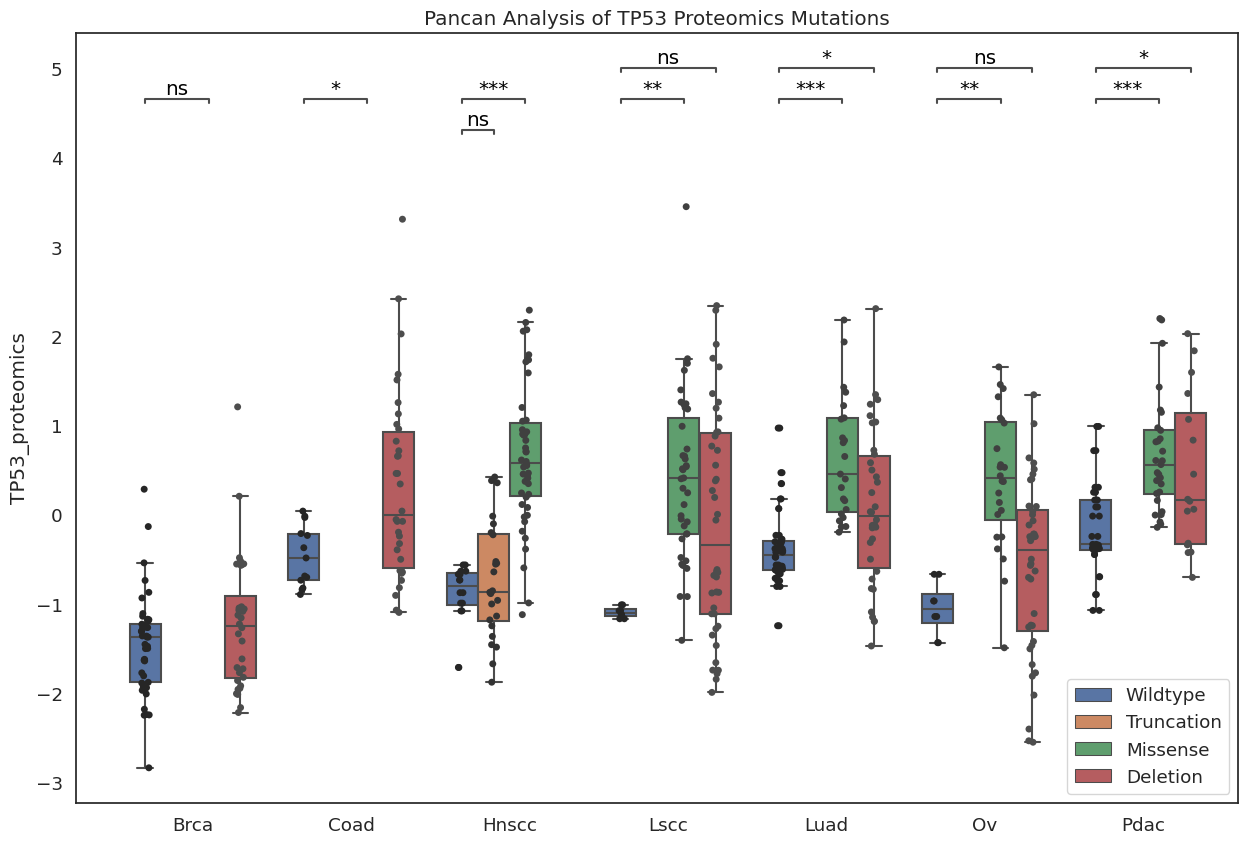

   Brca Deletions
   Coad Deletions
   Hnscc Truncations
   Hnscc Missenses
   Lscc Deletions
   Lscc Missenses
   Luad Deletions
   Luad Missenses
   Ov Deletions
   Ov Missenses
   Pdac Deletions
   Pdac Missenses
   Site   P_Value Cancer    Mutation
0  TP53  0.001088   Brca    Deletion
0  TP53  0.002978   Coad    Deletion
0  TP53  0.042574  Hnscc  Truncation
0  TP53  0.053426  Hnscc    Missense
0  TP53  0.966476   Lscc    Deletion
0  TP53  0.172714   Lscc    Missense
0  TP53  0.004989   Luad    Deletion
0  TP53  0.864058   Luad    Missense
0  TP53  0.168555     Ov    Deletion
0  TP53  0.112739     Ov    Missense
0  TP53  0.180313   Pdac    Deletion
0  TP53  0.071231   Pdac    Missense
Deletion
Deletion
Missense
Truncation
Deletion
Missense
Deletion
Missense
Deletion
Missense
Deletion
Missense
Series([], Name: cancer_type, dtype: int64)


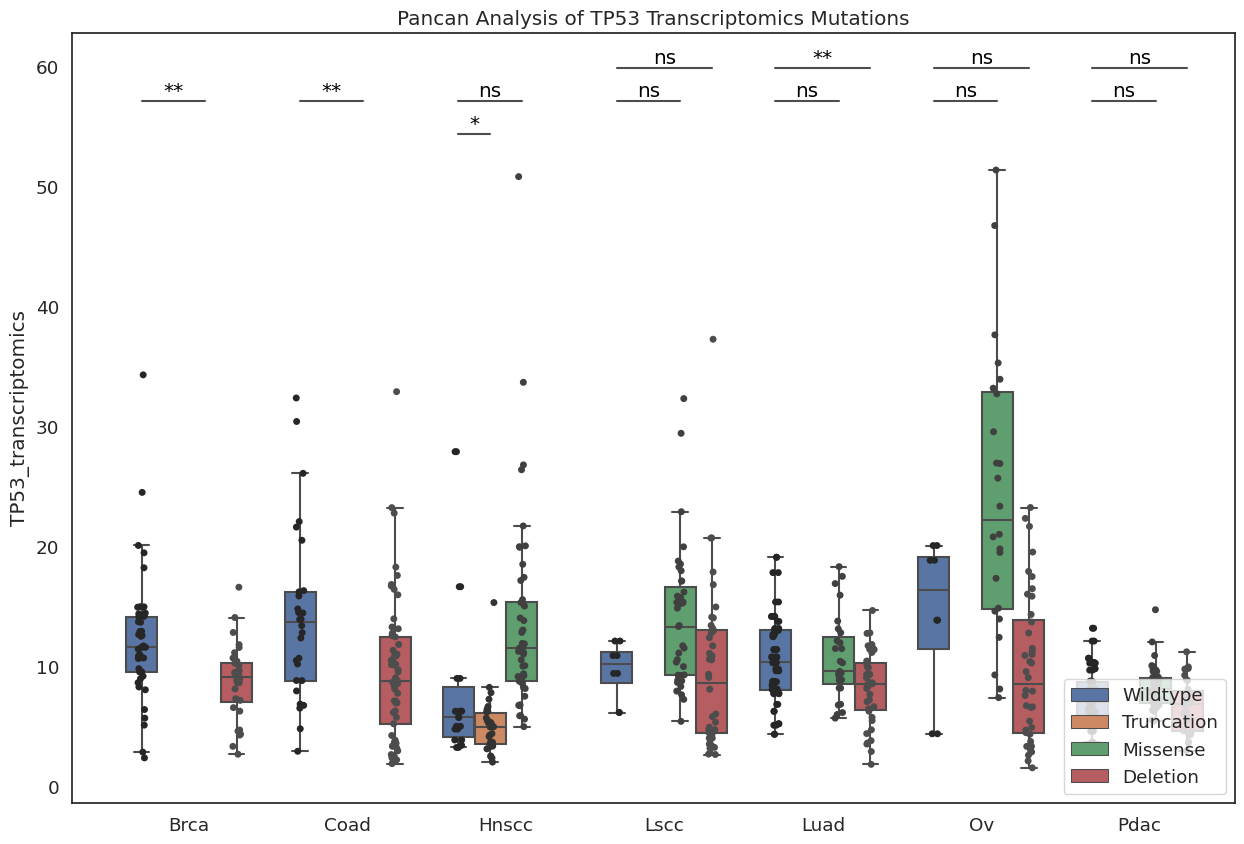

   Brca Deletions
    Not enough values for TP53_S149
   Coad Deletions
    Not enough values for TP53_S33
    Not enough values for TP53_S46
    Not enough values for TP53_S392
   Hnscc Truncations
    Not enough values for TP53_T150
   Hnscc Missenses
    Not enough values for TP53_T150
   Lscc Deletions
    Not enough values for TP53_T150
    Not enough values for TP53_S392
   Lscc Missenses
    Not enough values for TP53_T150
    Not enough values for TP53_S392
   Luad Deletions
    Not enough values for TP53_S314
    Not enough values for TP53_T81
   Luad Missenses
    Not enough values for TP53_S314
    Not enough values for TP53_T81
   Ov Deletions
    Not enough values for TP53_S314
   Ov Missenses
    Not enough values for TP53_S314
   Pdac Deletions
   Pdac Missenses
        Site   P_Value Cancer    Mutation
0  TP53_S315  0.326750   Brca    Deletion
0  TP53_S392  0.051427   Brca    Deletion
0  TP53_S315  0.000120   Coad    Deletion
0  TP53_S315  0.863029  Hnscc  Truncation
0 

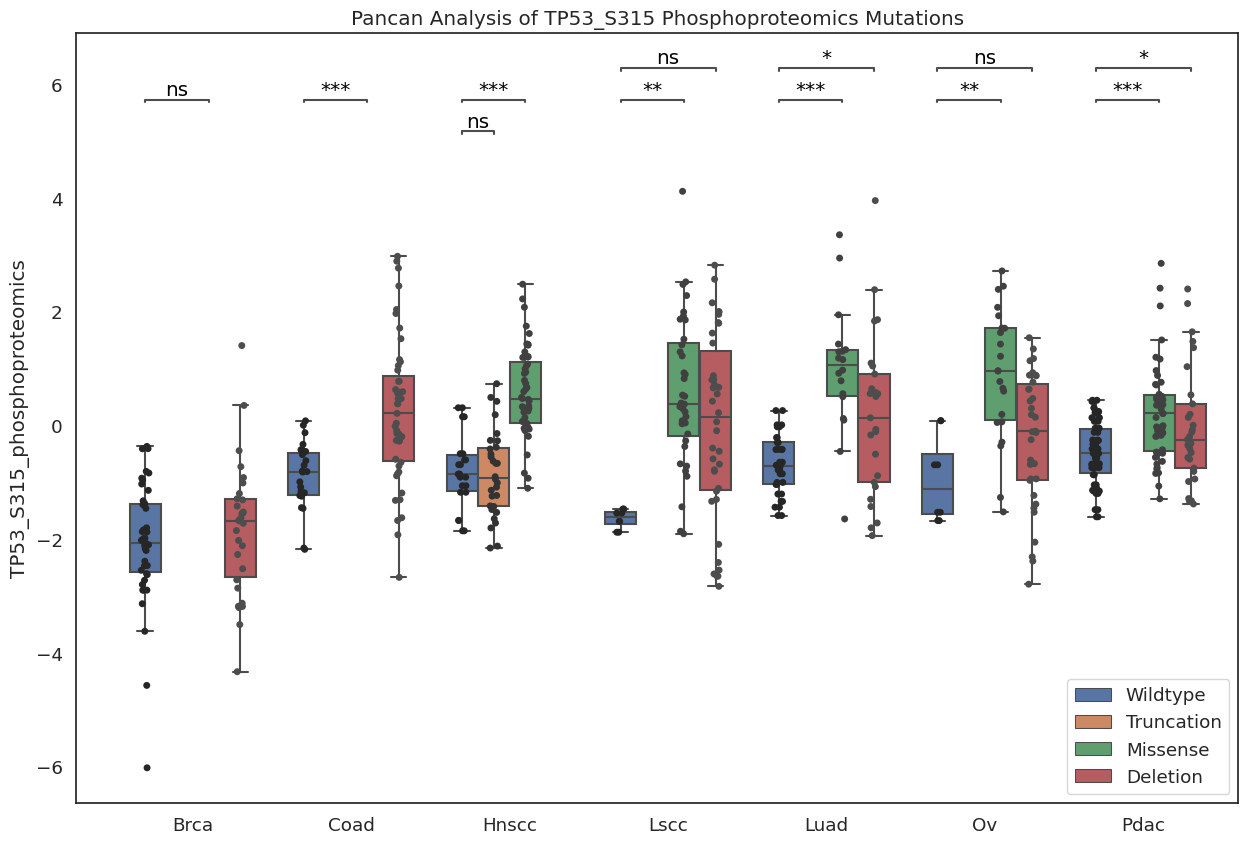

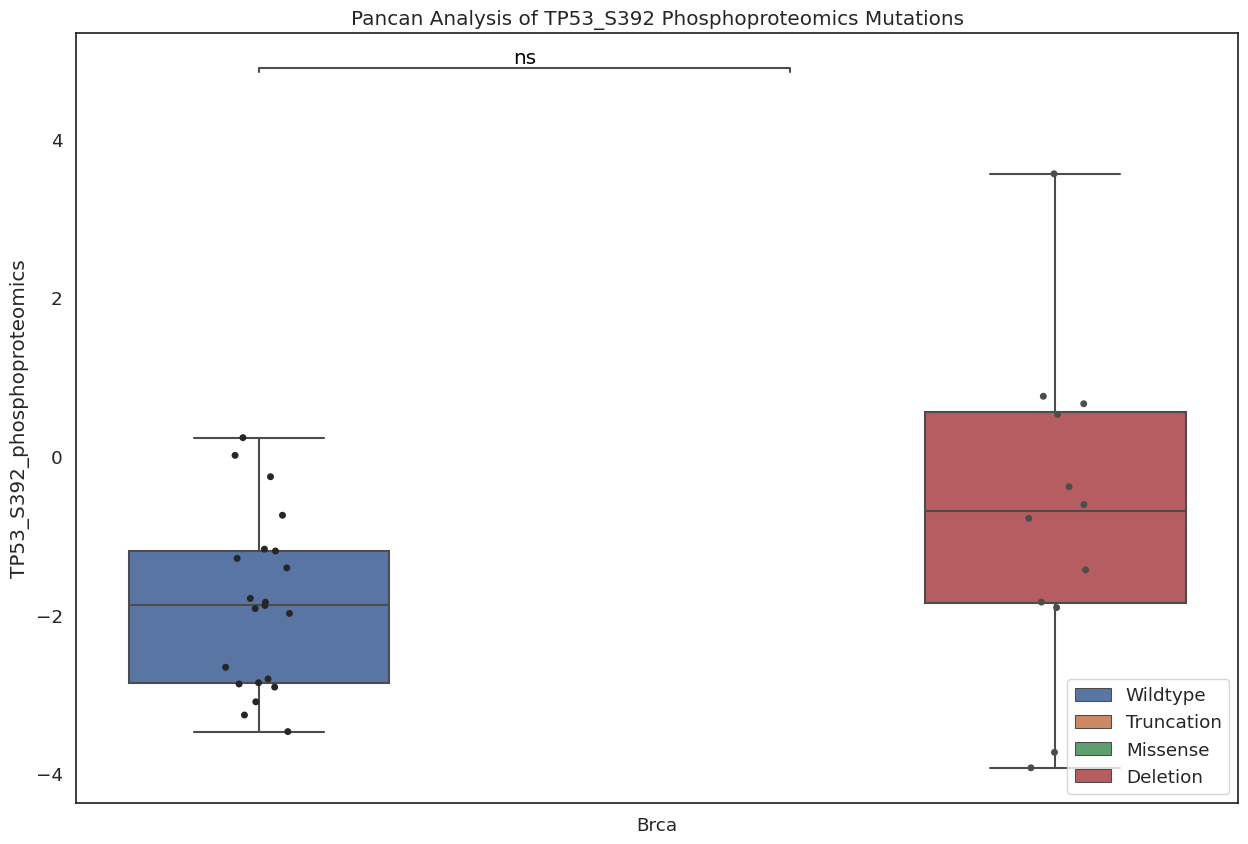

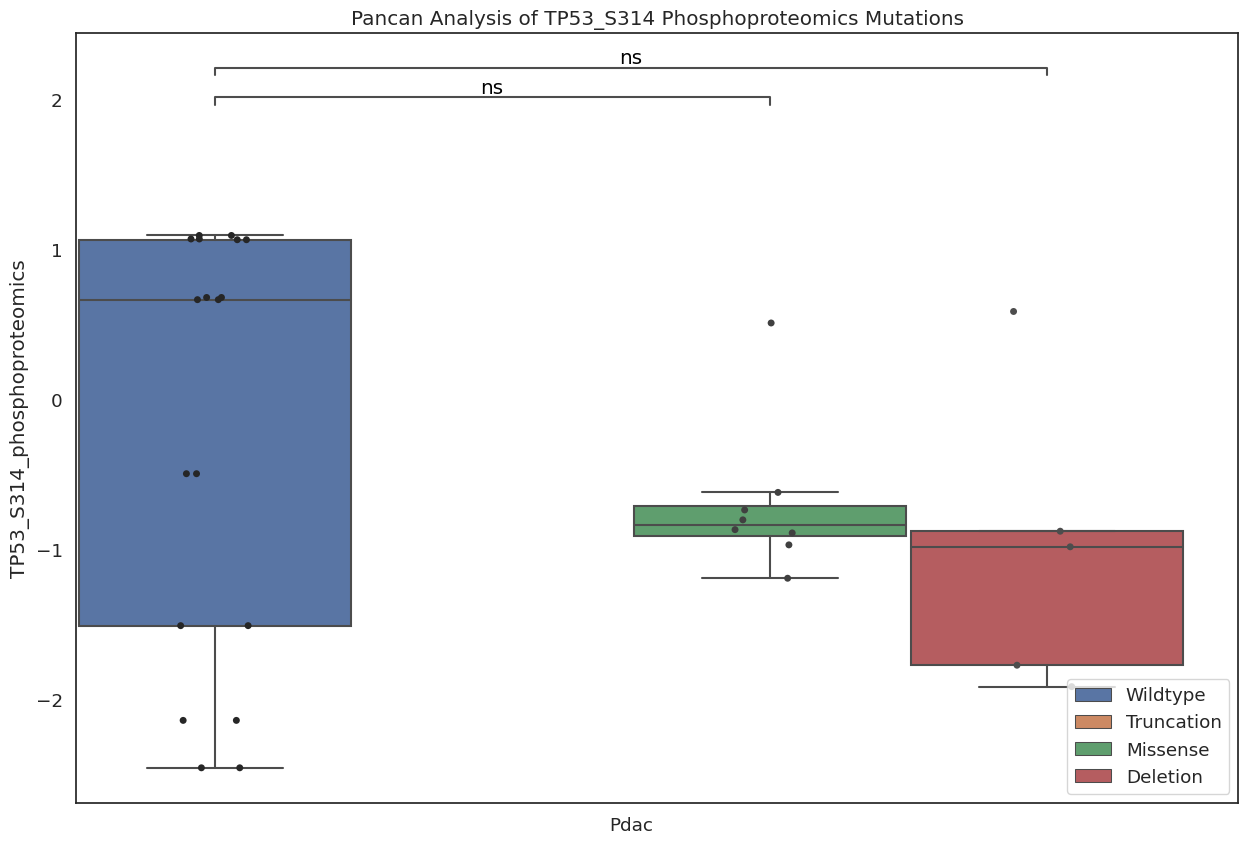

,Site,P_Value,Cancer,Mutation,Omics
0,TP53,1.290290e-01,Brca,Deletion,prot
1,TP53,1.428252e-02,Coad,Deletion,prot
2,TP53,4.883127e-01,Hnscc,Truncation,prot
3,TP53,1.459365e-06,Hnscc,Missense,prot
4,TP53,1.266779e-01,Lscc,Deletion,prot
5,TP53,2.513198e-03,Lscc,Missense,prot
6,TP53,1.920591e-02,Luad,Deletion,prot
7,TP53,7.294546e-08,Luad,Missense,prot
8,TP53,3.607840e-01,Ov,Deletion,prot
9,TP53,1.134811e-03,Ov,Missense,prot


In [127]:
cis_effects = pd.concat([analyze_cis_mutation(omics_type, genes_to_analyze=[target_gene], write_insignificant=True) for omics_type in ["prot", "trans", "phos"]])
# cis_effects = pd.concat([analyze_cis_mutation(omics_type, genes_to_analyze=[target_gene]) for omics_type in ["phos"]])

cis_effects.reset_index(drop=True, inplace=True)

cis_effects


# Part 4: Trans Effects
Determines which genes that, given a mutation, will change the expression in another protein's proteomics, transcriptomics, or phosphoproteomics.This analysis is repeated for every cancer, and every mutation type.

To reduce the computational intensity and the corrections needed, the scope will be restricted to genes that share specific pathways with the target gene. These pathways are hypothesized to be significant in the gene's function, and **must be specificed beforehand**, either at the beginning of this notebook or in the following cells.

The analysis will then be repeated for all genes in the dataset. As the number of comparisons is greater, the correction applied will be more substantial.

Writes out a file containing the infomation for each mutation and cancer, and creates boxplot summarizing the data

In [129]:
# if path_indices == []:
#     print()

In [130]:
            print(output)
interacting_proteins = ut.get_proteins_in_pathways(paths["pathway"].loc[path_indices], database = 'wikipathways')
interacting_proteins = set(interacting_proteins["member"])

# genes_measured = [gene for dataset in datasets.values() for gene in dataset["prot"].columns]
genes_measured = set([gene for gene in dataset["prot"].columns for dataset in datasets.values()])
genes_to_analyze = sorted([protein for protein in interacting_proteins if protein in genes_measured])
no_analysis = sorted([protein for protein in interacting_proteins if protein not in genes_measured])# debug temp

if target_gene in genes_to_analyze:
    genes_to_analyze.remove(target_gene)
print(f"Interacting genes: {len(interacting_proteins)}")
print(f"Not measured in cptac: {len(no_analysis)}") #debug temp
print(f"Genes to analyze: {len(genes_to_analyze)}")

NameError: name 'output' is not defined

In [131]:
def analyze_trans_mutation(omics_type, genes_to_analyze = None, write_out = True, file_name = None, output_boxplot = True, write_insignificant=False):
    """Analyzes the cis effects for a given mutation type across all cancers.
    
    Parameters:
    omics_type (str): The omics to analyze. Possible values are in list ["prot", "trans", "phos"]
    genes_to_analyze (list, default=None): The list of genes to consider for trans effects. Defaults to all genes in dataset, excluding target_gene
    write_out (bool, default=True): Whether to write out the data to a separate file.
    output_boxplot (bool, default=True): Outputs the data as a boxplot given by the generate_trans_plot function
    write_insignificant (bool, default=True): Returns data only when the p-value <= 0.05. If write_out, it only writes out the data under that condition.
    
    Returns the output of scipy.ttest_ind() between "Wildtype" and mutation_type tumors. If analyzing phosphoproteomics, returns a list of such outputs
    """
    if write_out:# Sets file name and clears target files
        import os
        if file_name is None:
            effect_type = "Cis" if genes_to_analyze == [target_gene] else "Trans"
            file_name = f"{effect_type}_Effect_output/{omics_key[omics_type].capitalize()}_Analysis_trans.txt"
        if '/' in file_name:
            directory = file_name[:file_name.rfind('/')]
            if not os.path.exists(directory):
                os.makedirs(directory)
        with open(file_name, 'w') as out_file: pass
                
                
    for cancer_type, dataset in datasets.items():
        ## PREPARE DATA ##
        genotype_and_omic = dataset[omics_type].copy()
        if isinstance(genotype_and_omic.columns, pd.MultiIndex):
            genotype_and_omic.columns = ['_'.join(col) for col in genotype_and_omic.columns.values]
        if genes_to_analyze is not None:
            genotype_and_omic = genotype_and_omic.filter(regex='(' + '|'.join(genes_to_analyze) + ')(_.*)?$', axis=1)
        else:
            genotype_and_omic.drop(genotype_and_omic.filter(regex = 'Test').columns, axis = 1, inplace = True)
        genotype_and_omic["Mutation"] = dataset["gen"]["Mutation"].copy()
        genotype_and_omic = genotype_and_omic.loc[:,~genotype_and_omic.columns.duplicated()]
        
        for mutation_type in mutation_types:
            if mutation_type not in variants_to_analyze[cancer_type]: 
                continue
            print(f"   {cancer_type} {mutation_type}s")

            target_mut_data = genotype_and_omic.loc[genotype_and_omic["Mutation"].isin(["Wildtype", mutation_type])]
   
            ## ANALYZE P-VALUES ##
            mutation_analysis = ut.wrap_ttest(target_mut_data, label_column="Mutation",
                                correction_method = "fdr_bh", return_all=True)
            mutation_analysis.rename({'Comparison':'Site'}, axis = 1, inplace = True)
            mutation_analysis['Cancer'], mutation_analysis['Mutation'] = cancer_type, mutation_type
            
            try:
                result = pd.concat([result, mutation_analysis])
            except NameError:
                result = mutation_analysis

            ## GATHER DATA FOR BOXPLOT ##
            if output_boxplot:
                new_data = genotype_and_omic[(genotype_and_omic["Mutation"] == mutation_type)|
                                            (genotype_and_omic["Mutation"] == "Wildtype")]
                new_data["cancer_type"] = cancer_type
                try:
                    boxplot_data = pd.concat([boxplot_data, new_data], axis=0)
                except NameError:
                    boxplot_data = new_data
    
    result.drop_duplicates(inplace=True)

    ## WRITE OUT RESULT ##
    if write_out:
        with open(file_name, 'a') as out_file:
            output = result.copy()
            for cancer in output["Cancer"].unique():
                for mutation in output["Mutation"].unique():
                    mut_data = output.loc[(output["Cancer"] == cancer)&(output["Mutation"] == mutation)]
                    if len(mut_data) == 0: 
                        continue
                    if not write_insignificant:
                        mut_data = mut_data.loc[mut_data['P_Value'] <= 0.05]
                    out_file.write(f"{cancer.upper()} {mutation.upper()}: ")
                    out_file.write(f"{len(mut_data.loc[mut_data['P_Value'] <= 0.05])} significant entries\n")
                    for row in mut_data.iterrows():
                        data = row[1]
                        out_file.write(f"   {data['Site']}:".ljust(15) + f"{data['P_Value']}\n")
                    out_file.write('\n')

    ## CREATE BOXPLOT ##
#     if output_boxplot:
#         pval_df = pd.DataFrame(pval_dict)
#         generate_cis_plot(boxplot_data, omics_type, pval_df) 
        
    return result

In [132]:
trans_effects = None
for omics_type in ["prot", "trans", "phos"]:
    print(omics_type.upper() + ':')
    data = analyze_trans_mutation(omics_type, genes_to_analyze=genes_to_analyze, write_insignificant=False)
    data["Omics"] = omics_type
    if trans_effects is not None:
        trans_effects = pd.concat([trans_effects, data])
    else:
        trans_effects = data
    print()
trans_effects.reset_index(drop=True, inplace=True)
trans_effects

PROT:
   Brca Deletions
   Coad Deletions
   Hnscc Truncations
   Hnscc Missenses
   Lscc Deletions
   Lscc Missenses
   Luad Deletions
   Luad Missenses
   Ov Deletions
   Ov Missenses
   Pdac Deletions
   Pdac Missenses

TRANS:
   Brca Deletions
   Coad Deletions
   Hnscc Truncations
   Hnscc Missenses
   Lscc Deletions
   Lscc Missenses
   Luad Deletions
   Luad Missenses
   Ov Deletions
   Ov Missenses
   Pdac Deletions
   Pdac Missenses

PHOS:
   Brca Deletions
   Coad Deletions
   Hnscc Truncations
   Hnscc Missenses
   Lscc Deletions
   Lscc Missenses
   Luad Deletions
   Luad Missenses
   Ov Deletions
   Ov Missenses
   Pdac Deletions
   Pdac Missenses



,Site,P_Value,Cancer,Mutation,Omics
0,CRK,0.000891,Brca,Deletion,prot
1,RACGAP1,0.008457,Brca,Deletion,prot
2,PFAS,0.044623,Brca,Deletion,prot
3,CCNB2,0.044623,Brca,Deletion,prot
4,TAOK1,0.044623,Brca,Deletion,prot
...,...,...,...,...,...
16584,RAD9A_S375S387,0.993700,Pdac,Missense,phos
16585,CDC25C_S216,0.994141,Pdac,Missense,phos
16586,PML_S512,0.994141,Pdac,Missense,phos
16587,BRAF_T753,0.996107,Pdac,Missense,phos


In [28]:
trans_effects_all = None
for omics_type in ["prot", "trans", "phos"]:
    print(omics_type.upper() + ':')
    data = analyze_trans_mutation(omics_type, genes_to_analyze=None, write_insignificant=False, file_name=f"Trans_Effect_output/{omics_key[omics_type].capitalize()}_Analysis_trans_ALL")
    data["Omics"] = omics_type
    if trans_effects_all is not None:
        trans_effects_all = pd.concat([trans_effects_all, data])
    else:
        trans_effects_all = data
    print()
trans_effects_all.reset_index(drop=True, inplace=True)
trans_effects_all

PROT:
   Brca Deletions
   Coad Deletions
   Hnscc Truncations
   Hnscc Missenses
   Lscc Deletions
   Lscc Missenses
   Luad Deletions
   Luad Missenses
   Ov Deletions
   Ov Missenses
   Pdac Deletions
   Pdac Missenses

TRANS:
   Brca Deletions
   Coad Deletions
   Hnscc Truncations
   Hnscc Missenses
   Lscc Deletions
   Lscc Missenses
   Luad Deletions
   Luad Missenses
   Ov Deletions
   Ov Missenses
   Pdac Deletions
   Pdac Missenses

PHOS:
   Brca Deletions


KeyboardInterrupt: 

# Part 5: Discussion
Looks for ptaterns in the analysis that will indicate meaningful conclusions

## 5.1: Overlapping Genes
A pan-cancer effect is, by definition, one that is present across many types of cancers. We will look at the most significant effects in each cancer for each mutation, and find the overlap with all other cancers and mutations.

In [133]:
from math import log
def find_common_effects(effects, omics_type, slice_by="percentile", slice_val=25, file_name = None):
    most_significant = []
    num_entries = 0
    for cancer in effects["Cancer"].unique():
        for mutation in effects["Mutation"].unique():
            data = effects.loc[(effects["Cancer"] == cancer) & (effects["Mutation"] == mutation) & (effects["Omics"] == omics_type)]
            # This slices the data based on what input parameter was put in
            if slice_by == "p_value":
                most_significant.append(data[data["P_Value"] < slice_val])
            elif slice_by == "rank":
                most_significant.append(data.head(slice_val))
            elif slice_by=="percentile":
                most_significant.append(data.head(int(len(data) * slice_val / 100)))

            #Not all combinations of cancer+mutation exist in dataframe; only counting those that do
            if len(data) > 0:
                num_entries += 1
    
    #Transforming into dataframe
    most_significant = pd.concat(most_significant)
    most_significant = most_significant["Site"].value_counts()
    most_significant = most_significant[most_significant > 1]
    
    #Everything below is just for outputting data
    import os
    if file_name is None:
        effect_type = "Cis" if genes_to_analyze == [target_gene] else "Trans"
        file_name = f"{effect_type}_Effect_output/{omics_key[omics_type].capitalize()}_Common_Effects_by_{slice_by}.txt"
    if '/' in file_name:
        directory = file_name[:file_name.rfind('/')]
        if not os.path.exists(directory):
            os.makedirs(directory)
    #Writing out file
    with open(file_name, 'w') as out_file:
        out_file.write(f"{target_gene} {omics_key[omics_type].capitalize()}\n")
        out_file.write(f"Total number of cancer+mutation types measured: {num_entries}\n")
        if slice_by=="p_value":
            out_file.write(f"Taking the genes where p < {slice_val}\n")
        elif slice_by=="rank":
            out_file.write(f"Taking the {slice_val} most significant genes from each\n")
        elif slice_by=="percentile":
            out_file.write(f"Taking the top {slice_val} percent most significant genes from each\n")
        out_file.write(most_significant.to_string())
    
    #Creating graph
    data = most_significant.copy()
    if len(data) > 40:
        data=data[:40]
    if len(data) <= 5:
        return most_significant # Graphs break when only one or fewer data points
    plt.rcParams["figure.figsize"]=[12,len(data)/1.5]
    data.plot.barh(legend=None)
    plt.gca().invert_yaxis()
    plt.xlim(0,num_entries)
    for idx, val in enumerate(data.values):
        plt.text(val-plt.xlim()[1]*.035, idx+0.15, str(val).rjust(2), fontsize=14, fontweight="bold", color="white")
    plt.suptitle(f"    Common {omics_key[omics_type].title()[:-1]} Trans Effects", fontsize=20, fontweight="bold", y=1.2-0.2*(log(len(data)/5))**.5)
    if slice_by=="p_value":
        chart_title=f"trans effects where p < {slice_val}"
    elif slice_by=="rank":
        chart_title=f"the top {slice_val} most significant trans effects"
    elif slice_by=="percentile":
        chart_title=f"the top {slice_val}% most significant trans effects"
    plt.title(f"(Considering {chart_title})", fontsize=18)
    plt.xlabel("Number of Cancer+Mutation Combinations in which Trans Effect was Observed", fontweight="bold", fontsize=14, y=1)
    plt.savefig(file_name.replace(".txt", ".png"), dpi=75)
    plt.show()
    
    return most_significant

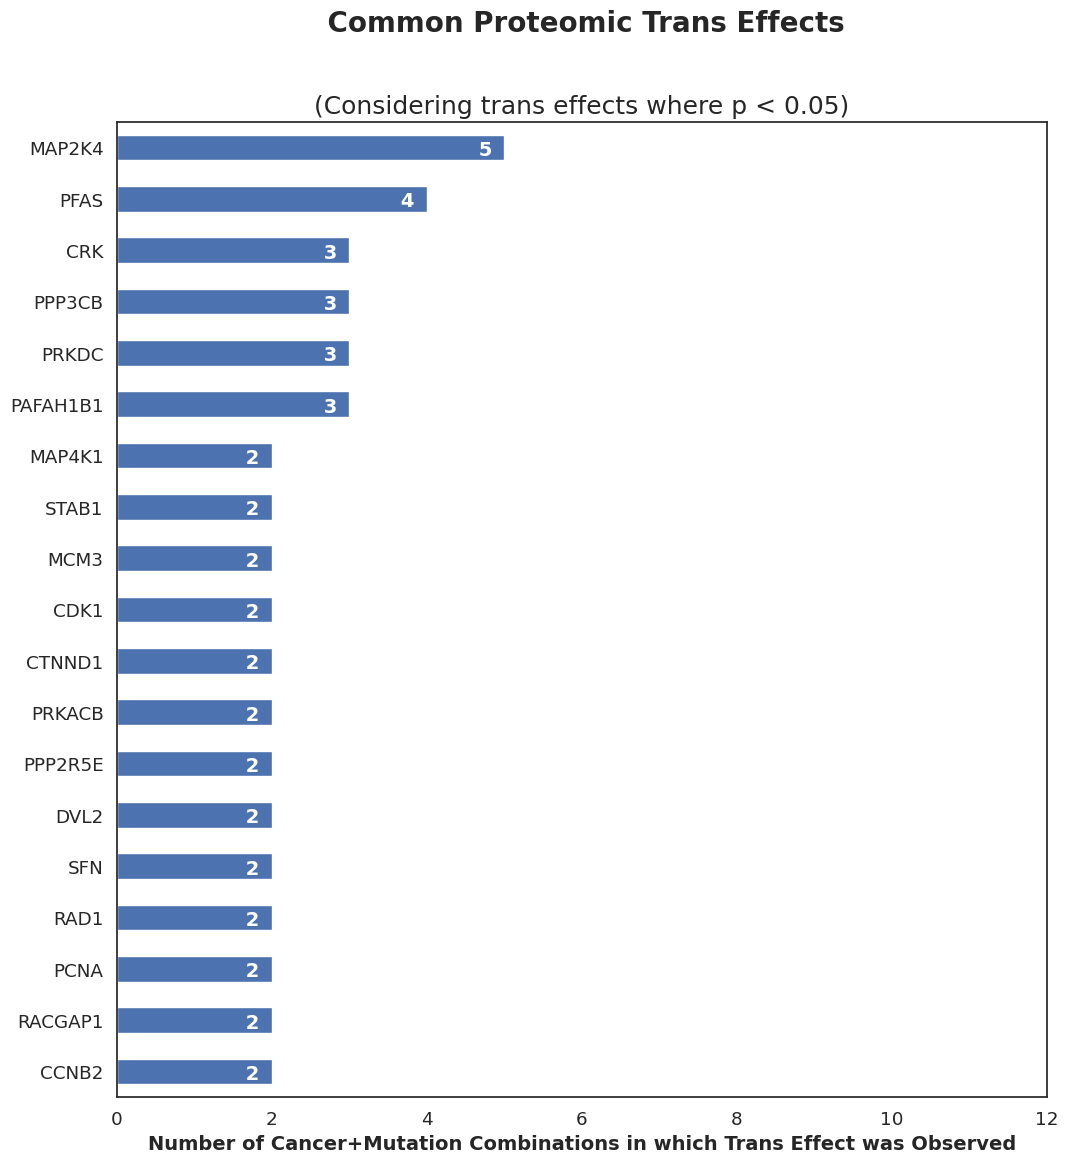

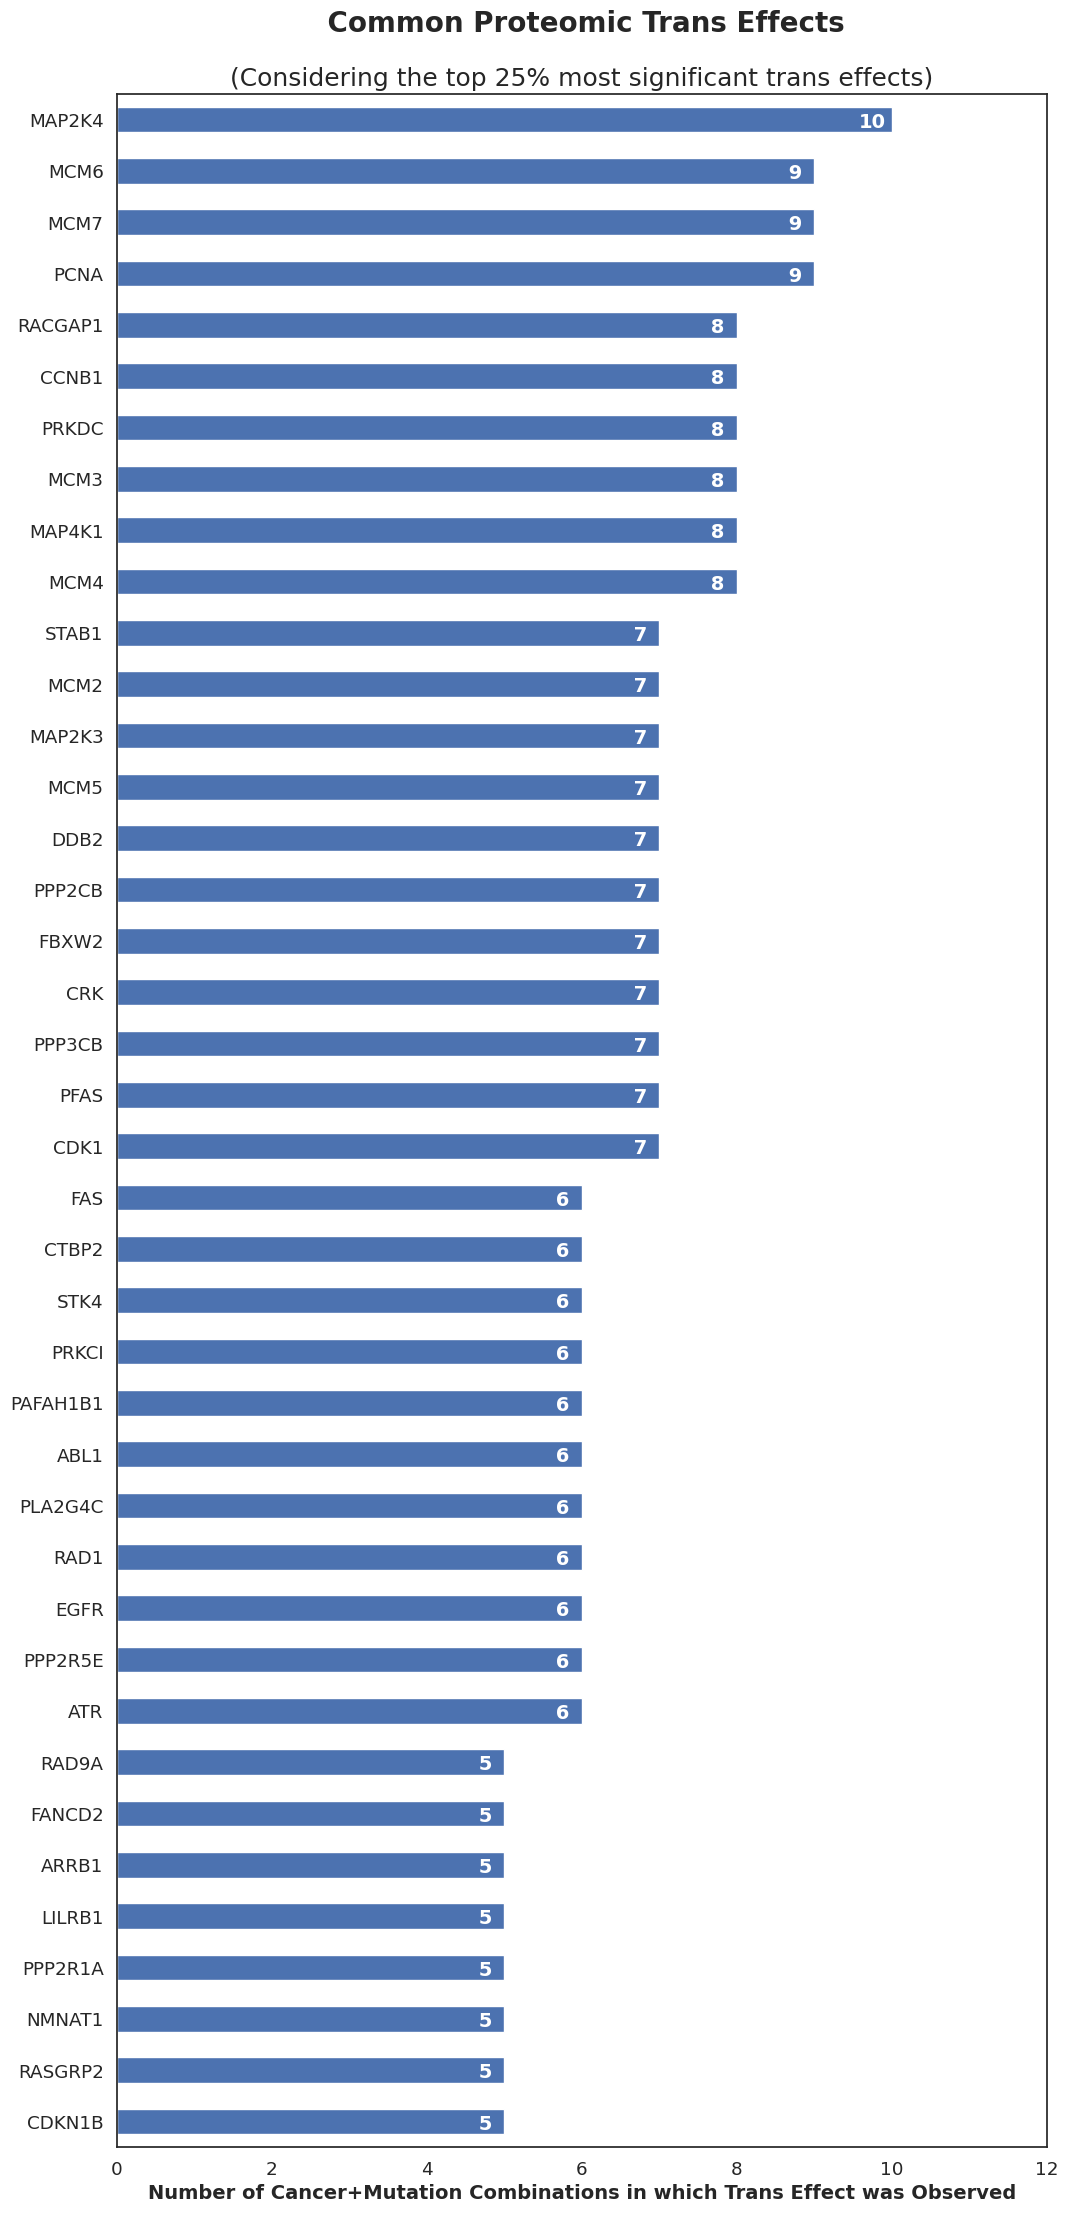

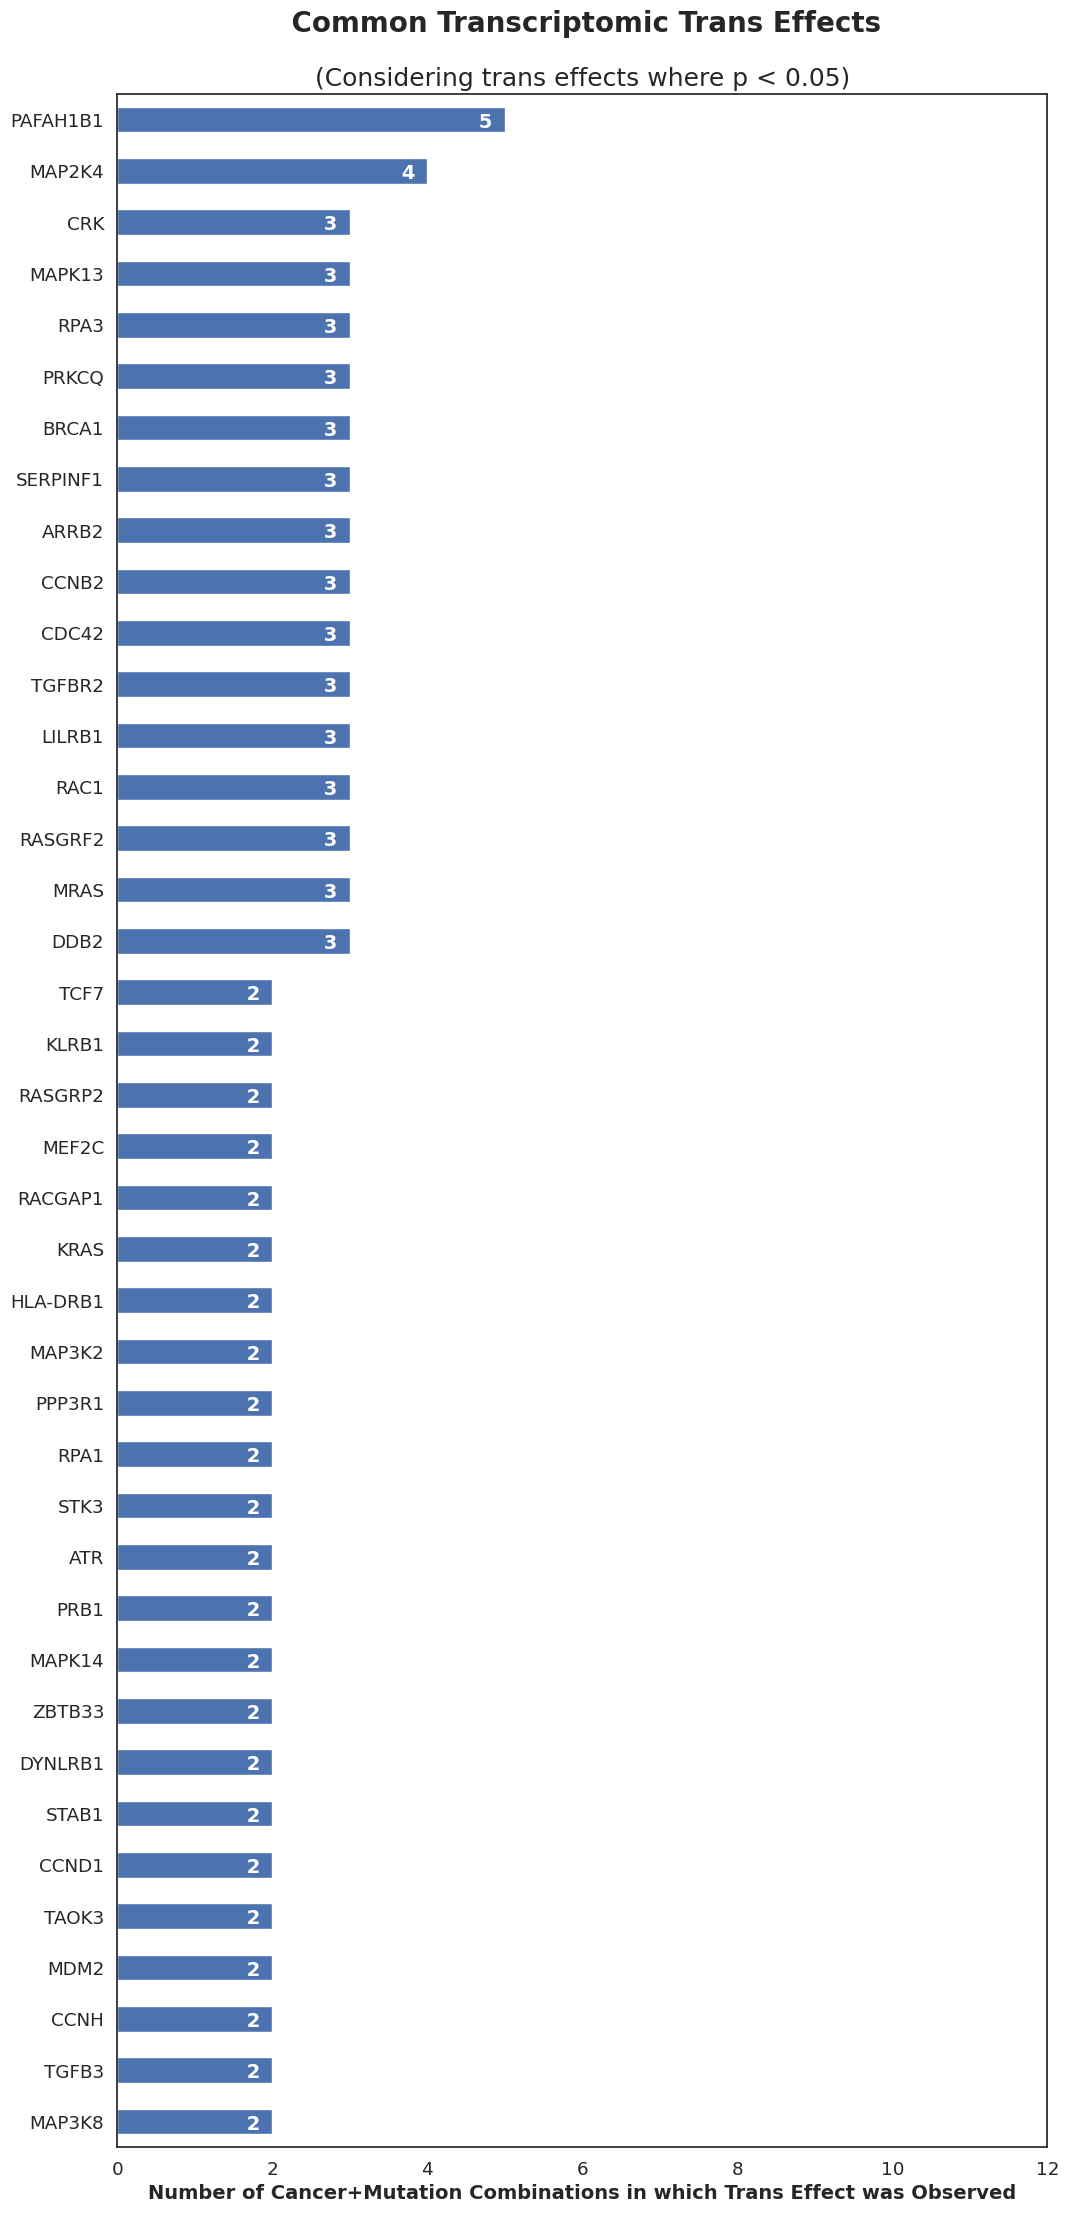

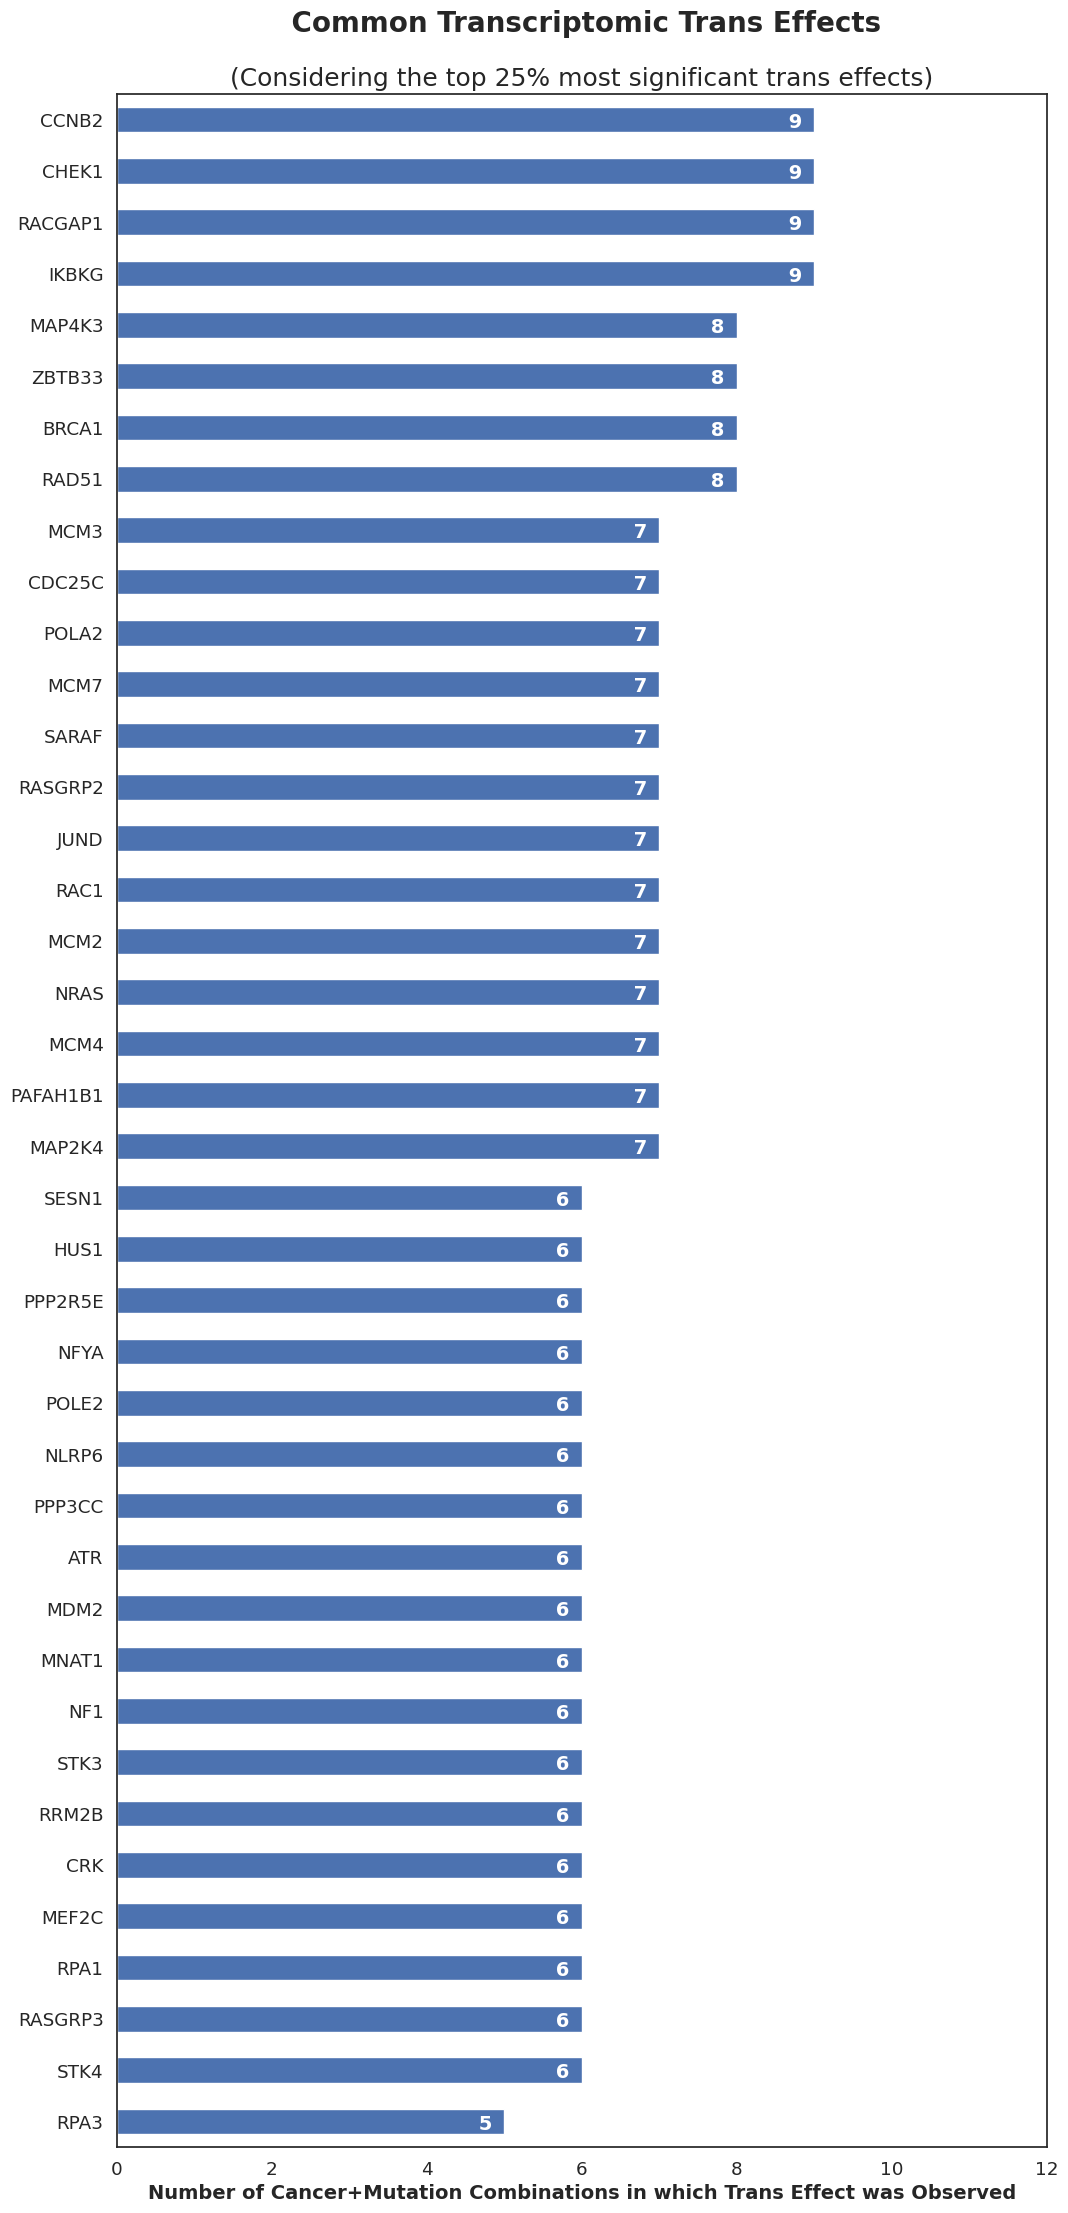

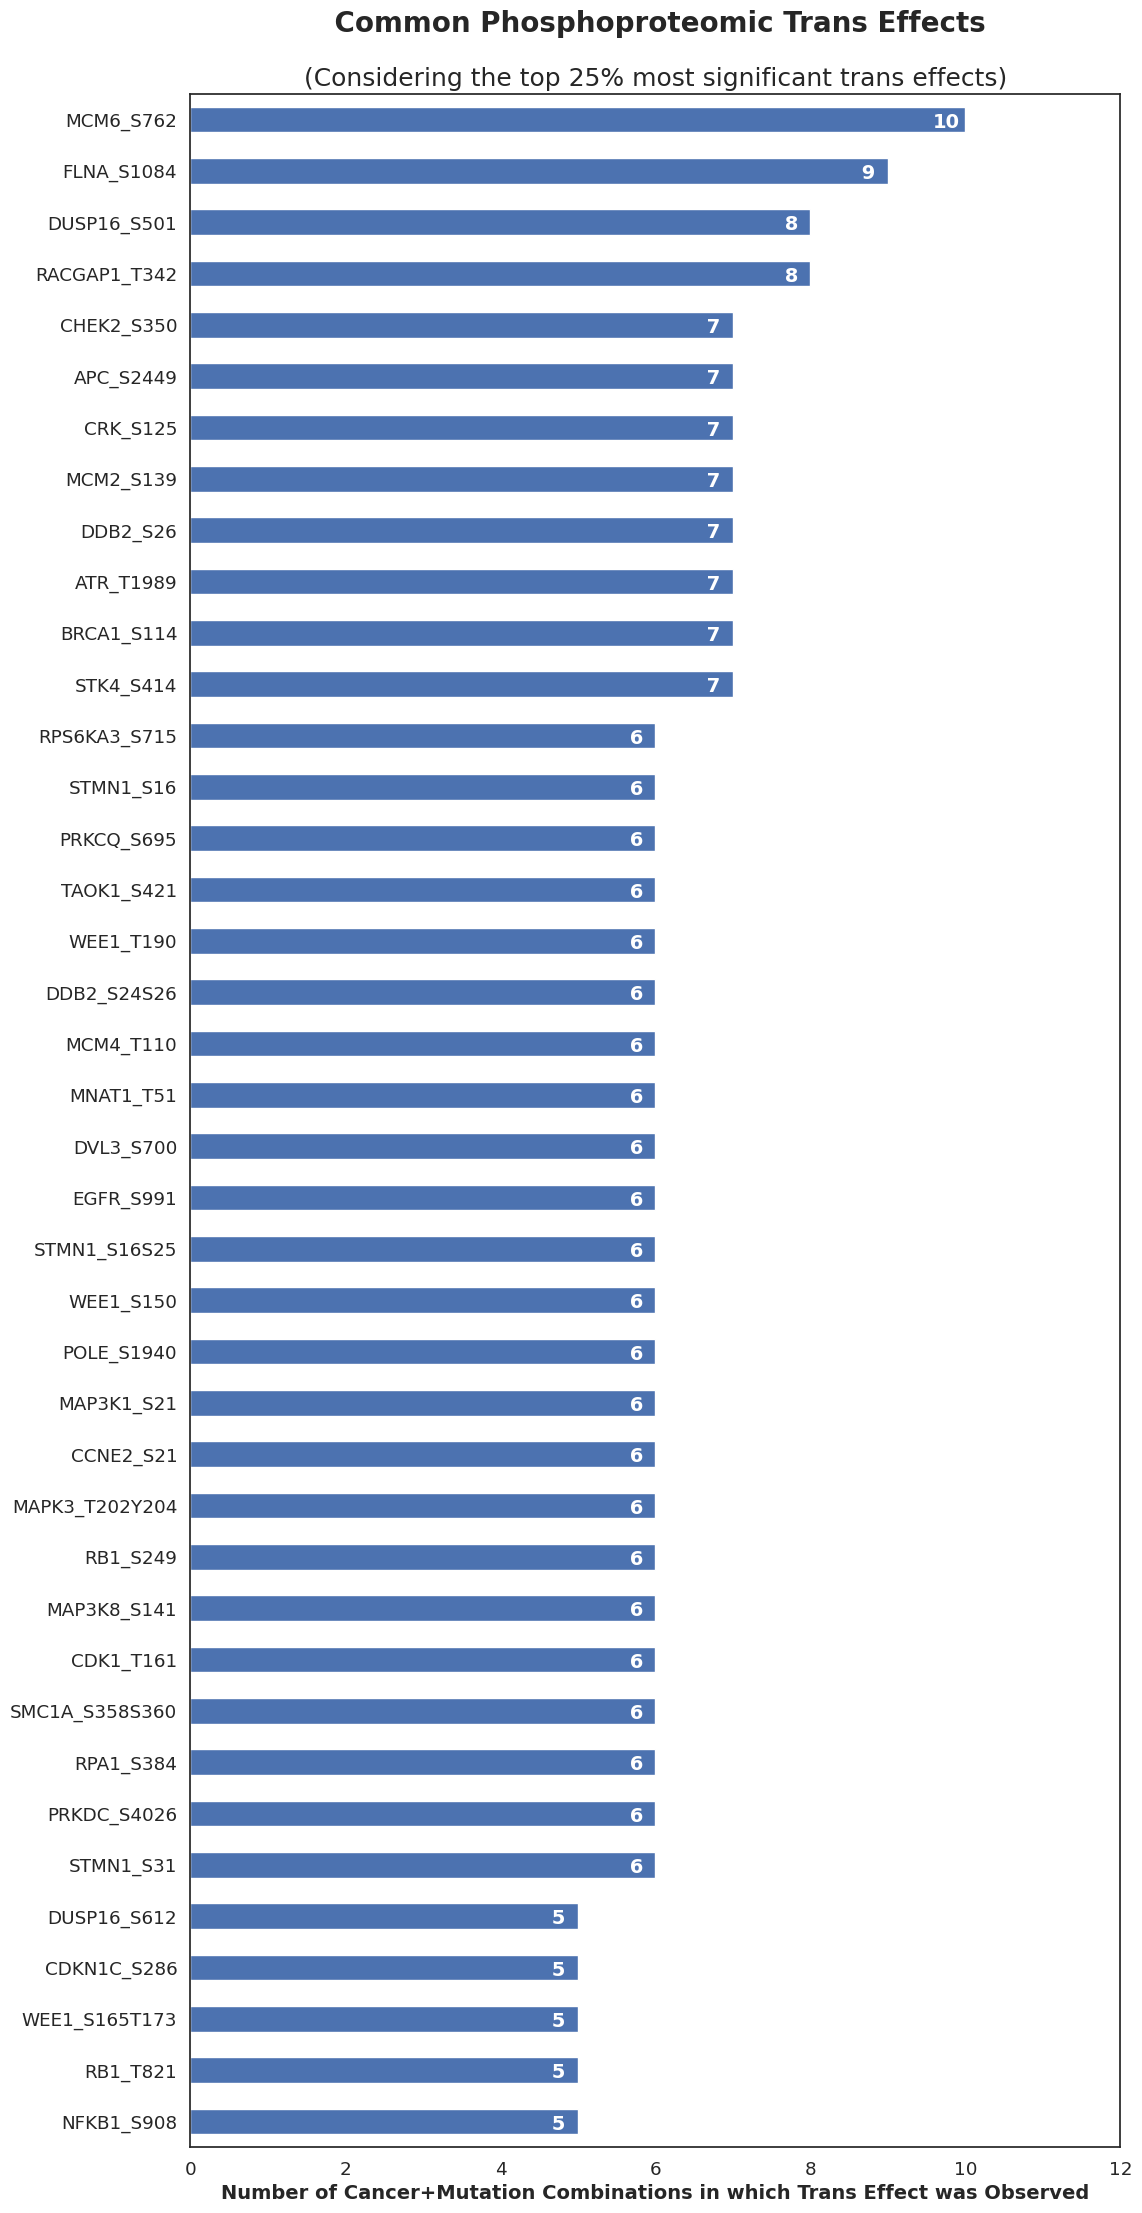

In [134]:
for omics in ["prot", "trans", "phos"]:
    find_common_effects(trans_effects, omics, slice_by="p_value", slice_val=0.05)
    find_common_effects(trans_effects, omics, slice_by="percentile", slice_val=25)
#     find_common_effects(trans_effects_all, omics, file_name=f"Trans_Effect_output/{omics_key[omics].capitalize()}_Common_Effects_All_by_p_value.txt", slice_by="p_value", slice_val=0.05)
#     find_common_effects(trans_effects_all, omics, file_name=f"Trans_Effect_output/{omics_key[omics].capitalize()}_Common_Effects_All_by_percentile.txt", slice_by="percentile", slice_val=25)

## 5.2: Pathway Enrichment

In [ ]:
# from gprofiler import GProfiler
# cancer = "Brca"
# mutation = "Deletion"

# up_in_mutation = trans_effects.loc[(trans_effects["Cancer"]==cancer)&
#                                    (trans_effects["Mutation"]==mutation)&
#                                    (trans_effects["Omics"] == "prot")]["Site"]
# up_in_mutation = list(up_in_mutation)
# up_in_mutation

In [ ]:
# GProfiler(return_dataframe=True).profile(organism='hsapiens', query=up_in_mutation)

In [ ]:
# enrichments = {cancer + '_' + mutation : set(GProfiler(return_dataframe=True).profile(organism='hsapiens', query=up_in_mutation)["name"])
#                 for cancer in trans_effects["Cancer"]
#                 for mutation in trans_effects["Mutation"]}
# enrichments
#Taking a long time

In [ ]:
# enrichments = {}
# omics_effects = trans_effects.loc[trans_effects["Omics"] == "prot"]
# for cancer in omics_effects["Cancer"].unique():
#     cancer_effects = omics_effects.loc[omics_effects["Cancer"] == cancer]
#     for mutation in cancer_effects["Mutation"].unique():
#         print(cancer+'_'+mutation)
#         query = list(trans_effects.loc[(trans_effects["Mutation"]==mutation)]["Site"])
#         enrichments[cancer+'_'+mutation] = GProfiler(return_dataframe=True).profile(organism='hsapiens', query=query)
#         enrichments[cancer+'_'+mutation]
#         break
#     break
# enrichments

In [ ]:
# enrichments["Brca_Deletion"]

### TEMP
This is junk that will be deleted soon

In [ ]:
#DELETE THIS CELL
#I use this to let me know when the data has finished loading
import webbrowser
webbrowser.open("https://www.youtube.com/watch?v=dQw4w9WgXcQ")